# 1. Notebook Setup

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

Import libraries

In [2]:
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.serialize import model_from_json, model_to_json
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import eda as eda

Importing plotly failed. Interactive plots will not work.


# 2. Loading and Prepare data

Load CSV

In [3]:
df = pd.read_csv("../data/Folsom_irradiance.csv", infer_datetime_format=True)
df

,timeStamp,ghi,dni,dhi
0,2014-01-02 08:00:00,0.0,0.0,0.0
1,2014-01-02 08:01:00,0.0,0.0,0.0
2,2014-01-02 08:02:00,0.0,0.0,0.0
3,2014-01-02 08:03:00,0.0,0.0,0.0
4,2014-01-02 08:04:00,0.0,0.0,0.0
...,...,...,...,...
1552315,2016-12-31 07:55:00,0.0,0.0,0.0
1552316,2016-12-31 07:56:00,0.0,0.0,0.0
1552317,2016-12-31 07:57:00,0.0,0.0,0.0
1552318,2016-12-31 07:58:00,0.0,0.0,0.0


Convert `timeStamp` to a datetime and set as index

In [4]:
df["ds"] = pd.to_datetime(df["timeStamp"])
# df = df.set_index('DS')

Drop other columns (only GHI needed for ARIMA)

In [5]:
df["y"] = df["ghi"]
df = df[["ds", "y"]]

In [6]:
df

,ds,y
0,2014-01-02 08:00:00,0.0
1,2014-01-02 08:01:00,0.0
2,2014-01-02 08:02:00,0.0
3,2014-01-02 08:03:00,0.0
4,2014-01-02 08:04:00,0.0
...,...,...
1552315,2016-12-31 07:55:00,0.0
1552316,2016-12-31 07:56:00,0.0
1552317,2016-12-31 07:57:00,0.0
1552318,2016-12-31 07:58:00,0.0


Split train/test

In [7]:
# Split data into train and test based on the years
train_start = "2014-01-01"
# validation_start = "2015-01-01"
test_start = "2016-01-01"

train_data = df.loc[df["ds"] < test_start]
# validation_data = df.loc[(validation_start <= df.index) & (df.index < test_start)]
test_data = df.loc[df["ds"] >= test_start]

Ensure no data leakage by checking date range of each sample created

In [8]:
# eda.print_df_index_date_range(train_data, "Train")
# # eda.print_df_index_date_range(validation_data, "Validation")
# eda.print_df_index_date_range(test_data, "Test")

Check for missing values in ghi

In [9]:
# assert df.isnull().any() == False

# # for c in ["ghi", "dni", "dhi"]:
# #     df[c]=df[c].fillna(method='ffill')

Check if data is stationary over a day: **non-stationary**, will need to use at least a difference order of 1

# 3. Train Prophet Model

Takes ~ 15 minutes on full train test (all 2014 and 2015)

In [10]:
# # Create a Prophet model instance
# model = Prophet()

# model.fit(df)

# with open('../output/prophet_univariate_serialized_model.json', 'w') as fout:
#     fout.write(model_to_json(model))  # Save model

Takes ~10 seconds

In [11]:
with open('../output/prophet_univariate_serialized_model.json', 'r') as fin:
    model = model_from_json(fin.read())  # Load model

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


# 4. Make Forecasting Predictions

Loop through each minute prediction from 1 to 20, forecasts the next minute step using the ARIMA model, stores the forecasted values in a DataFrame, calculates the errors at each minute prediction, and plots the mean absolute error at each forecast horizon.

In [15]:
# future = model.make_future_dataframe(periods=20, freq='min')  # 20 minutes with 1-minute intervals
# future



In [13]:
future = test_data[["ds"]]
future = future.loc[future["ds"] < '2016-01-02']

future

,ds
1029600,2016-01-01 08:00:00
1029601,2016-01-01 08:01:00
1029602,2016-01-01 08:02:00
1029603,2016-01-01 08:03:00
1029604,2016-01-01 08:04:00
...,...
1030555,2016-01-01 23:55:00
1030556,2016-01-01 23:56:00
1030557,2016-01-01 23:57:00
1030558,2016-01-01 23:58:00


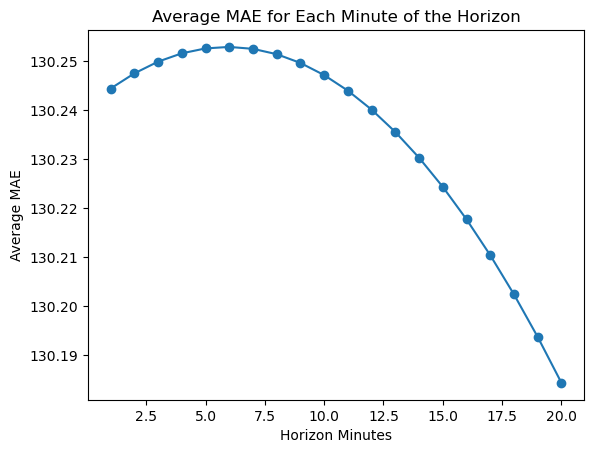

In [16]:
# Make predictions for the future
forecast = model.predict(future)

# Extract the forecasted values for the test set (the last 20 minutes)
forecast_test = forecast.iloc[-20:]

# Initialize lists to store MAE for each minute of the horizon
mae_per_minute = []

# Iterate over each minute of the horizon (from 1 to 20)
for minute in range(1, 21):
    # Filter the forecasted values up to the current minute
    forecast_until_minute = forecast.iloc[:minute]
    
    # Filter the actual values up to the current minute
    actual_until_minute = test_data.iloc[:minute]
    
    # Calculate MAE for this minute and append it to the list
    mae = mean_absolute_error(actual_until_minute['y'], forecast_until_minute['yhat'])
    mae_per_minute.append(mae)

# Plot the average error for each minute of the horizon
plt.plot(range(1, 21), mae_per_minute, marker='o')
plt.xlabel('Horizon Minutes')
plt.ylabel('Average MAE')
plt.title('Average MAE for Each Minute of the Horizon')
plt.show()

In [12]:
future = model.make_future_dataframe(periods=len(test_data), freq='min')

,ds,y
1029600,2016-01-01 08:00:00,0.0
1029601,2016-01-01 08:01:00,0.0
1029602,2016-01-01 08:02:00,0.0
1029603,2016-01-01 08:03:00,0.0
1029604,2016-01-01 08:04:00,0.0
...,...,...
1039595,2016-01-08 06:35:00,0.0
1039596,2016-01-08 06:36:00,0.0
1039597,2016-01-08 06:37:00,0.0
1039598,2016-01-08 06:38:00,0.0


/tmp/ipykernel_20532/2799380640.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future = future.append(test_batch[['ds']], ignore_index=True)


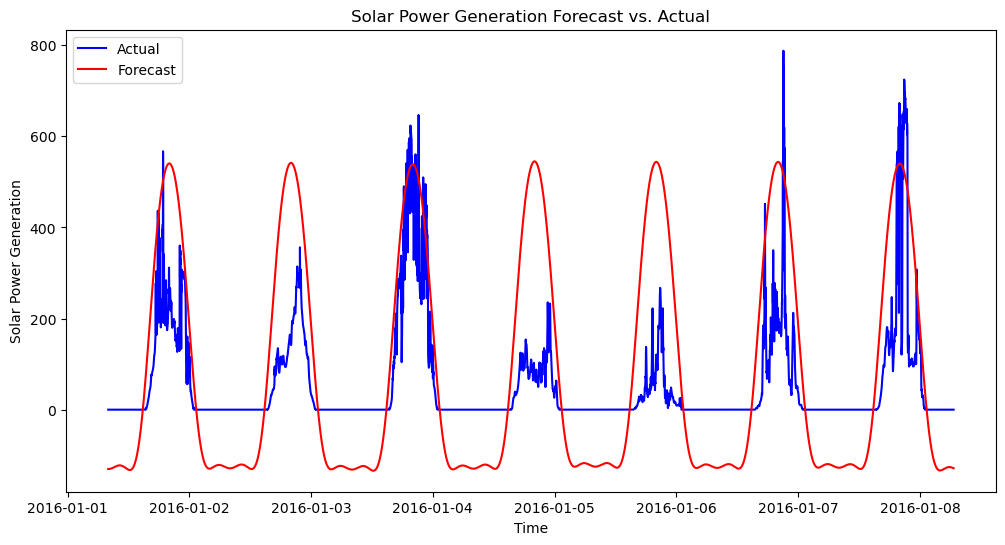

Mean Absolute Error (MAE) for the entire test set: 153.35554065656933


In [18]:
# Set the batch size for making predictions
batch_size = 10000  # Adjust as needed based on your available memory

# Initialize lists to store forecasted values and actual values
forecast_values = []
actual_values = []

# Loop through the test dataset in batches
for i in range(0, len(test_data), batch_size):
    # Extract a batch of test data
    test_batch = test_data.iloc[i:i + batch_size]
    
    # Update the future DataFrame with the current batch of test data
    future = future.append(test_batch[['ds']], ignore_index=True)
    
    # Make predictions for the current batch
    forecast = model.predict(future[-len(test_batch):])
    
    # Append the forecasted values to the list
    forecast_values.extend(forecast['yhat'].values)
    
    # Append the actual values to the list
    actual_values.extend(test_batch['y'].values)
    break

# Calculate the mean absolute error (MAE) for the entire test set
mae = mean_absolute_error(actual_values, forecast_values)

# Plot the forecasted vs. actual values for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_data[:10000]['ds'], actual_values, label='Actual', color='b')
plt.plot(test_data[:10000]['ds'], forecast_values, label='Forecast', color='r')
plt.xlabel('Time')
plt.ylabel('Solar Power Generation')
plt.title('Solar Power Generation Forecast vs. Actual')
plt.legend()
plt.show()

print(f'Mean Absolute Error (MAE) for the entire test set: {mae}')